In [1]:
import numpy as np
import cv2
import copy
import os, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\User\Petr\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
from MyUtils import transforms, utils, engine, train as transforms, utils, engine, train
from MyUtils.utils import collate_fn
from MyUtils.engine import train_one_epoch, evaluate
from MyUtils.plot_statistic import plot_stats
from MyUtils.visulaize import visualize
import MyUtils.Dataset

In [3]:
def train_transform():
    return A.Compose([
        A.OneOf([
        A.Sequential([
            A.RandomRotate90(p=0.5), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True, always_apply=False, p=0.5), # Random change of brightness & contrast
            #A.ToGray(p=1),
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.5, 0.5), p=1),
            A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5)
            ]),
        A.Sequential([
            A.RandomScale(scale_limit=0.1, interpolation=1, always_apply=False, p=0.5)
        ]),
    ], p=1.0)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def eval_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            #A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.5), contrast_limit=(-0.2, 0.2), brightness_by_max=True, always_apply=False, p=1.0), # Random change of brightness & contrast
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.5, 0.5), p=1)
        ], p=1)
    ],
    #keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def test_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.0), contrast_limit=0.0, brightness_by_max=True, always_apply=False, p=1.0), # Random change of brightness & contrast
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.1, 0.9), p=1)
        ], p=1)
    ])

In [5]:
path = 'C:/Users/User/Petr/Net_3/Dataset/'

Lenght of dataset is: 205
Maximum number of corners per pillar is: 3


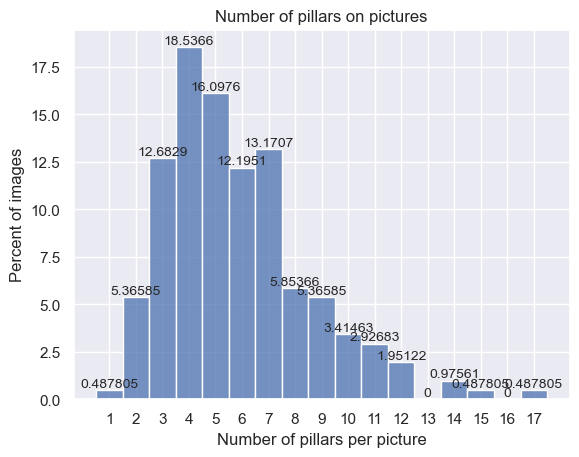

In [11]:
dataset = MyUtils.Dataset.PillarsDataset(path, transform=None, demo=False)

dataset.explore

In [12]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

idx = torch.IntTensor.item(batch[1][0]['image_id'])

print(f'ID: {dataset.inner_id}')

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp for kp in kps])

print(bboxes)
visualize(image, bboxes, keypoints, save_path=os.path.join(path, 'check_dataset', '1.jpg'))

ID: 212
[[125, 3233, 426, 3467], [1339, 3188, 1499, 3315], [1709, 816, 1772, 887], [4082, 1969, 4203, 1987], [2883, 2847, 3010, 2944]]


Lenght of dataset is: 205
Maximum number of corners per pillar is: 3


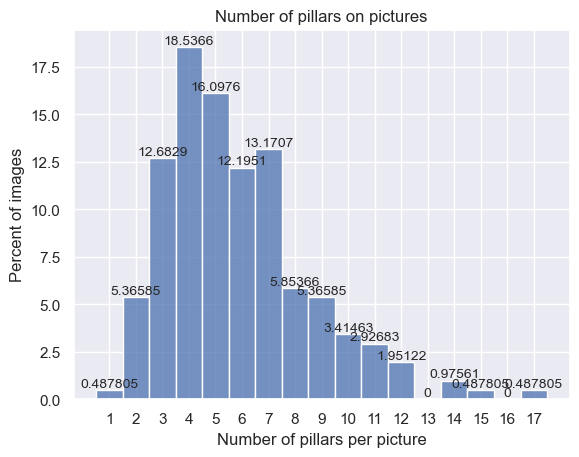

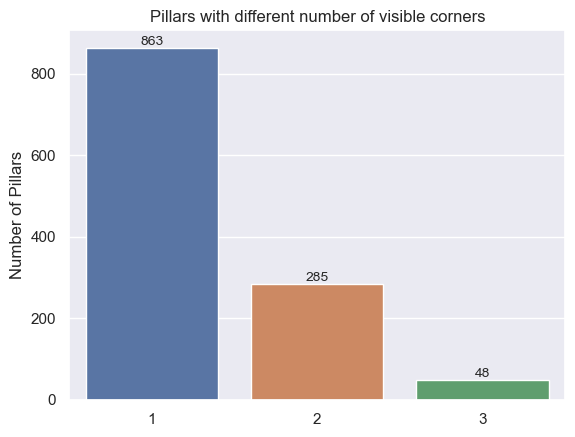

In [6]:
dataset = MyUtils.Dataset.PillarsDataset(path, transform=train_transform(), demo=True)
dataset.explore

ID: 62
[[723, 1087, 847, 1160], [770, 895, 884, 991], [2401, 1130, 2426, 1188]]
[[[842, 1157, 1], [0, 0, 0], [0, 0, 0]], [[825, 990, 1], [882, 949, 1], [0, 0, 0]], [[2416, 1187, 1], [0, 0, 0], [0, 0, 0]]]


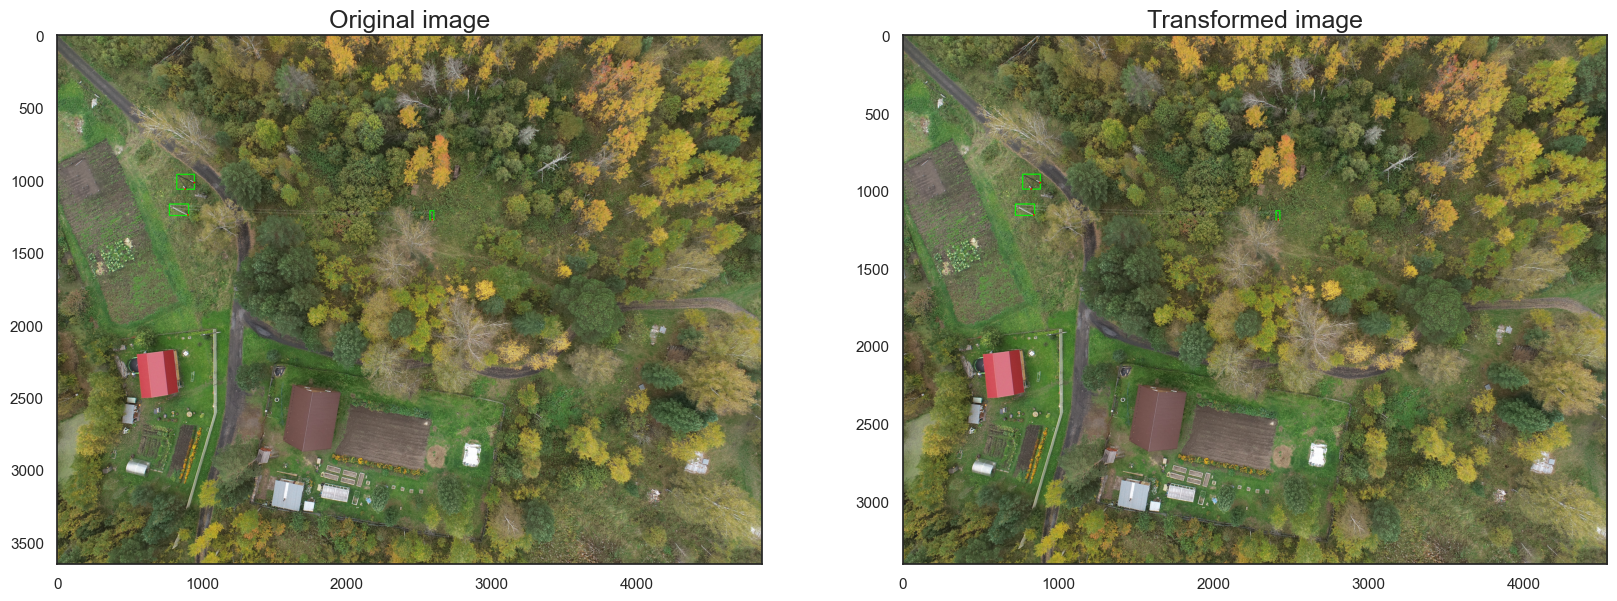

In [7]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original, save_path=os.path.join(path, 'check_dataset', '1.jpg'))
print(f'ID: {dataset.inner_id}')
print(bboxes)
print(keypoints)

In [ ]:
def get_pillar_detection_model(num_classes, pretrain=True, weights_path=None):
    from torch import nn
    import torchvision
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    from torchvision.models.detection.rpn import AnchorGenerator
    # load a model pre-trained pre-trained on COCO
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0))
    
    if pretrain:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT', min_size=1500, max_size=5000, class_weigth=[1.0, 3.0])
    else:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1) # lenght of classes WITHOUT background on input
    
    #model.rpn.anchor_generator = anchor_generator
    
#    model.roi_heads.box_predictor.cls_score = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 2))
    
#    model.roi_heads.box_predictor.bbox_pred = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 8))
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [ ]:
model = get_pillar_detection_model(num_classes=5)

#print(model)

In [ ]:
#model_path = 'C:/Users/User/Petr/Net_1/Source/save_model/model_weights_fourth_Alb_0.38.pth'
#classes = {'Building': 1}
#path = 'C:/Users/User/Petr/temp_images'

#model_d = load_model(model_path)

#backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features

In [ ]:
for num in range(1):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
    
    KEYPOINTS_FOLDER_TRAIN = './Dataset'
    KEYPOINTS_FOLDER_EVAL = './Dataset'

    dataset_train = PillarsDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
    dataset_test = PillarsDataset(KEYPOINTS_FOLDER_EVAL, transform=eval_transform(), demo=False)

    indices = torch.randperm(len(dataset_train)).tolist()
    thirty_pc = int(len(dataset_train) * 0.20)
    dataset_train = torch.utils.data.Subset(dataset_train, indices[:-thirty_pc])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-thirty_pc:])




    data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
    data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = get_pillar_detection_model(num_classes=2,
                                      weights_path='./save_model/weights_6.pth')#, weights_path='./save_model/weights_rebuild_model_2.pth'


    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    #params1 = [p for p in model.roi_heads.keypoint_head.parameters() if p.requires_grad]
    
    optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.90)#, weight_decay=0.0001
    
    #optimizer = torch.optim.SGD([{'params': params1},
    #                             {'params': model.roi_heads.keypoint_predictor.parameters(), 'lr': .001},], lr=0.001, momentum=0.90)#, weight_decay=0.0001
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)
    num_epochs = 10

    #kps_stats = []
    bbox_stats = []

    loss_bb = []
    loss_cls = []
    #loss_kp = []
    loss = []

    for epoch in range(num_epochs):
        logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
        lr_scheduler.step()
        evaluator = evaluate(model, data_loader_test, device)
        
        #kps_stats.append(evaluator.coco_eval['keypoints'].stats[:6])
        
        #TODO: Change lr_scheduler step and gamma after Nth epoch
        
        bbox_stats.append(evaluator.coco_eval['bbox'].stats[:6])
    
        loss_bb.append(logger.meters['loss_box_reg'].global_avg)
        loss_cls.append(logger.meters['loss_classifier'].global_avg)
        #loss_kp.append(logger.meters['loss_keypoint'].global_avg)
        loss.append(logger.meters['loss'].global_avg)

    plot_stats(num_epochs, bbox_stats, loss_bb, loss_cls, loss)#, num=num
#print(type(meters[0]['loss_keypoint']))

# Save model weights after training
#torch.save(model.state_dict(), './save_model/weights_2.pth')
    torch.save(model.state_dict(), './save_model/weights_6.pth')

In [ ]:
def cut_score(predictions: dict, score_thresh = 0.5):
    cut_index = None
    for indx, score in enumerate(predictions['scores']):
        if score < score_thresh:
            cut_index = indx
            break
    if not cut_index:
        cut_index = len(predictions['scores']) - 1
    new_pred = {}

    new_pred['boxes'] = pred['boxes'][:cut_index]
    new_pred['labels'] = pred['labels'][:cut_index]
    new_pred['scores'] = pred['scores'][:cut_index]

    return new_pred

In [ ]:
torch.save(model.state_dict(), './save_model/weights_6.pth')

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks, save_image

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#model = get_pillar_detection_model(num_classes=2, weights_path='./save_model/weights_6.pth')

#model.to(device)

im_path_test = 'C:/Users/User/Petr/Net_3/test_model/images/'
color = {1: (255, 0, 0), 2: (0, 255, 0)}
#print(os.listdir(im_path_test))
for im in os.listdir(im_path_test):
    image = cv2.imread(im_path_test + im)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    eval_transforms = eval_transform()

    model.eval()
    with torch.no_grad():
        #x = eval_transforms(image=image)
        #x = x['image']
        x = F.to_tensor(image)
    #sample = self.transforms(image=image,
    #                                 bboxes=boxes,
    #                                 class_labels=labels,
    #                                 cropping_bbox=cropping_bbox)
    # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
    #x = x.to(device)
        predictions = model([x, ])
        pred = predictions[0]
        #pred = cut_score(predictions=pred, score_thresh=0.5)
    #print(pred)
    image = torch.from_numpy(image)
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    
    scores = pred['scores'].detach().cpu().numpy()
    high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
    post_nms_idxs = torchvision.ops.nms(pred['boxes'][high_scores_idxs], pred['scores'][high_scores_idxs], 0.3).cpu().numpy()
    bboxes = []
    #print(pred['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy())
    for bbox in pred['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        #print(bbox)
        bboxes.append(list(map(int, bbox.tolist())))
        #bboxes.append(bbox)
    
    bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
    #print(bboxes)
    labels = []
    for label in pred['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        labels.append(label)
        
    scores_clear = []
    for score in pred['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        scores_clear.append(score)
#print(image.shape, image.dtype)
#image = image[:3, ...]
#print(image.shape, image.dtype)
    pred_labels = [f"{classes[label]}: {score:.3f}" for label, score in zip(labels, scores_clear)]
    #pred_boxes = pred["boxes"].long()
    colors = [color[label] for label in labels]
    print(labels)
    if len(bboxes) > 0:
        output_image = draw_bounding_boxes(image=image.permute(2, 0, 1), boxes=bboxes, colors=colors, width=5, font_size=50, font='./TimesNewRomanRegular.ttf')#labels=pred_labels,   
    else:
        output_image = image.permute(2, 0, 1)
    save_image(output_image / 255, './test_model/pred/' + im[:-4] + '_pred.jpg')


In [ ]:
import os
path = './Dataset/temp/'
for image in os.listdir(path):
    os.rename(path + image, path + image[:-4] + '_rod' + image[-4:])

In [ ]:
# Save model weights after training
torch.save(model.state_dict(), './save_model/weights_rebuild_model_summer.pth')

In [ ]:
KEYPOINTS_FOLDER = './'
dataset_test = ClassDataset(KEYPOINTS_FOLDER, transform=None, demo=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_keypoints = 17, weights_path='./save_model/weights.pth')
model.to(device);

In [ ]:
data_loader_test_1 = DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=collate_fn)
iterator = iter(data_loader_test_1)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

#print("Predictions: \n", output)

In [ ]:
image = cv2.imread('./check_model/temp3.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = F.to_tensor(img)
img = img.to(device)
images = [img]
with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)
    
#print(output)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_V2(num_keypoints = 9, weights_path='./save_model/weights_new_dataset.pth')
model.to(device);
#print(model)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

path = 'C:/Users/User/Desktop/Teobox_Shipunovo_2022-10-16T21.03.14/export_shapes_2/shape_556/'
path_E = './check_model/images'

images = []



for num, label in enumerate(os.listdir(path_E)):
    #print(os.path.join(path_E, label))
    #if num >= 15:
    #    break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path_E, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)
    img = img.to(device)
    images.append((img, label))

images_t = []
for num, label in enumerate(os.listdir(path_E)):
    #if num >= 15:
    #    break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path_E, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = F.to_tensor(img)
    #img = img.to(device)
    images_t.append((img, label))
#print(type(images[0][0]))
images_transformed = []
for pair in images_t:
    #img = A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1)(image=pair[0])['image']
    #img = A.InvertImg(p=1)(image=img)['image']
    #img = A.Sharpen(alpha=(0.1, 0.9), p=1)(image=img)['image']
    img = test_transform()(image=pair[0])['image']
    img = F.to_tensor(img)
    img = img.to(device)
    images_transformed.append(img)
with torch.no_grad():
    model.to(device)
    model.eval()
    images_to_pred = images_transformed
    output = model(images_to_pred)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_V2(num_keypoints = 9, weights_path='./save_model/weights_rebuild_model_3.pth')
model.to(device);
#print(model)

In [ ]:
path = 'C:/Users/User/Desktop/Teobox_Shipunovo_2022-10-16T21.03.14/export_shapes/shape_401/'
path_E = 'C:/Users/User/Petr/Net_2/test_dataset/two_dataset/eval/images'

images = []



for num, label in enumerate(os.listdir(path)):
    if num >= 15:
        break
    if 'world' in label:
        continue
    img = cv2.imread(os.path.join(path, label))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)
    img = img.to(device)
    images.append((img, label))
#print(images)
with torch.no_grad():
    model.to(device)
    model.eval()
    images_to_pred = [image for (image, label) in images]
    output = model(images_to_pred)

In [ ]:
def get_object_detection_model(num_classes):
    from torch import nn
    import torchvision
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.rpn import AnchorGenerator
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # lenght of classes WITHOUT background on input
    
#    model.roi_heads.box_predictor.cls_score = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 2))
    
#    model.roi_heads.box_predictor.bbox_pred = nn.Sequential(nn.Linear(1024, 512), nn.Linear(512,256), nn.Linear(256, 128), nn.Linear(128, 8))

    return model


def load_model(filepath: str):   
    model = get_object_detection_model(num_classes=2)
    model.load_state_dict(torch.load(filepath))
    return model



In [ ]:
for image, out in zip(images, output):
    label = image[1][:-4] + 'big_ds'
    image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    scores = out['scores'].detach().cpu().numpy()


    high_scores_idxs = np.where(scores > 0.75)[0].tolist() # Indexes of boxes with scores > 0.7
    post_nms_idxs = torchvision.ops.nms(out['boxes'][high_scores_idxs], out['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes
#    print(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0])
    if not len(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
        good_kps_idxs = [[]]
    else:
        good_kps_idxs = np.where(out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0] > 0.0) # for i in range(len(post_nms_idxs))
#    print(good_kps_idxs[0])
#    print('KPs: ', out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0][good_kps_idxs[0]])
    #kps_scores_filtered = out['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0][good_kps_idxs[0]]
#print(kps_scores_filtered)

#kps_filtered =  output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
#out['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
#print(kps_filtered)

    keypoints = []
    for kps in out['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        keypoints.append([list(map(int, kp)) for kp in kps[good_kps_idxs[0]]])
#kps_idxs = np.where(output[0]['keypoints_scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()[0] > 1.2)[0]
#print(kps_idxs)
#print(np.array(keypoints)[0][kps_idxs])
#keypoints = [np.array(keypoints)[0][kps_idxs].tolist()]
    print(keypoints)
#keypoints = average_close_points(keypoints)
#print(keypoints)
    
    bboxes = []
    for bbox in out['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        bboxes.append(list(map(int, bbox.tolist())))
    

    
    visualize(image, bboxes, keypoints)

In [ ]:
import shutil

for file in two_corner_files:
    #shutil.copy(f'./test_dataset/train/images/{file}.jpg', f'./test_dataset/two_dataset/train/images/{file}.jpg')
    #shutil.copy(f'./test_dataset/train/annotations/{file}.txt', f'./test_dataset/two_dataset/train/annotations/{file}.txt')
    
    shutil.copy(f'./test_dataset/eval/images/{file}.jpg', f'./test_dataset/two_dataset/eval/images/{file}.jpg')
    shutil.copy(f'./test_dataset/eval/annotations/{file}.txt', f'./test_dataset/two_dataset/eval/annotations/{file}.txt')
    
for file in three_corners_files:
    #shutil.copy(f'./test_dataset/train/images/{file}.jpg', f'./test_dataset/three_dataset/train/images/{file}.jpg')
    #shutil.copy(f'./test_dataset/train/annotations/{file}.txt', f'./test_dataset/three_dataset/train/annotations/{file}.txt')
    
    shutil.copy(f'./test_dataset/eval/images/{file}.jpg', f'./test_dataset/three_dataset/eval/images/{file}.jpg')
    shutil.copy(f'./test_dataset/eval/annotations/{file}.txt', f'./test_dataset/three_dataset/eval/annotations/{file}.txt')

In [ ]:
import shutil

for file in os.listdir('./annotations/'):
    if file[:-4] not in extra_annotations:
        shutil.copy(f'./annotations/{file}', f'./annotations_clear/{file}')

In [ ]:
#import numpy as np

def average_close_points(point_coords): 
    #point_coords = np.array([point[:-1] for point in point_coords[0]])
    point_coords = np.array(point_coords[0])
    maping = np.abs(point_coords[:, None, None] - point_coords[None, :, None]) <= 3
    print(maping)
    maping = maping.reshape(maping.shape[0], maping.shape[1], 3)
    print(maping)
    res = []
    for point in maping:
        res.append(np.average(point_coords, axis=0, weights=point))
    #point_coords = np.average(point_coords, axis=0, weights=maping)
    
    return [np.unique(res, axis=0).astype(int)]

In [ ]:
average_close_points(keypoints)

In [ ]:
from torchview import draw_graph

model_v = get_model(num_keypoints=4)

model_graph = draw_graph(model_v, input_size=(1, 3, 128, 128))
model_graph.visual_graph

In [ ]:
from torch import nn
from torch.nn import functional as Fnn

class MyModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,kernel_size=(2,2),stride=1,padding='valid')
        self.conv1_1 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(2,2),stride=1,padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(2,2),stride=1,padding='valid')
        self.conv2_2 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(2,2),stride=1,padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.dropout1 = nn.Dropout(0.5)
        self.linear1 = nn.Linear(in_features=32*149*149,out_features=500)
        self.linear2 = nn.Linear(in_features=500,out_features=250)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(in_features=250,out_features=18)


    def forward(self,x):
        #x = cv2.resize(x, (600, 600))
        x = Fnn.relu(self.conv1(x))
        x = Fnn.relu(self.conv1_1(x))
        x = self.maxpool1(x)
        x = Fnn.relu(self.conv2(x))
        x = Fnn.relu(self.conv2_2(x))
        x = self.maxpool2(x)
        #print(x.shape)
        x = x.view(-1,32*149*149) 
        x = self.dropout1(x)
        x = Fnn.relu(self.linear1(x))
        x = Fnn.relu(self.linear2(x))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x


In [ ]:
model_self = MyModel()

criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
#device = torch.device('cuda')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_self.to(device)
# Training loop
num_epochs = 5

KEYPOINTS_FOLDER_TRAIN = './NEW_DATASET'
KEYPOINTS_FOLDER_EVAL = './NEW_DATASET'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_EVAL, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader_train):
         # [[[x, y, v], [x, y, v], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0], [0 , 0, 0]]]
        points = [point for point in labels[0]['keypoints'][0]]
        kps = []
        for point in points:
            x, y, v = point
            kps.append([(x-600)/600, (y-600)/600])
        #kps = [(x, y) for point in points for x, y, v in point]
        #kps.reshape(1, 8)
        #print(kps)
        #print(images[0].numpy())
        images = cv2.resize(images[0].numpy().transpose(1,2,0), (600, 600))
        #print(images)
        images = F.to_tensor(images).cuda()
        labels = torch.as_tensor(kps).cuda()
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_self(images).to(device)
        #print(outputs)
        labels = labels.view(-1, 18)
        #print(labels)
        loss = torch.sqrt(criterion(outputs, labels))
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Print Epoch, Step and Loss value.
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(data_loader_train), loss.item()))

In [ ]:
import re
def has_cyrillic(text):
    return bool(re.search('[а-яА-Я]', text))

path = 'C:/Users/User/Petr/Net_2/test.jpg'

has_cyrillic(path)

In [ ]:
image = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(image)